In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CA_model import *
from virus_CA import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

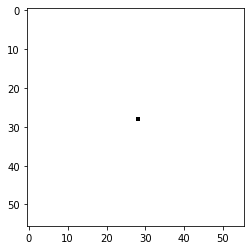

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

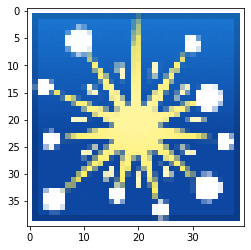

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
target = target.cpu()
loss_fn(pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

(tensor(0.2883), tensor(0))

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [7]:
# loads a pretrained model
old_CA = CAModel().to(device)
old_CA.load("firework_growing.pt")

Successfully loaded model!


In [8]:
new_CA = CAModel().to(device)
new_CA.load("new_CA.pt")

Successfully loaded model!


In [9]:
# Define the virus model
mask_CA = CAModel().to(device)
mask_CA.load("mask_CA.pt")
model = VirusCA2(old_CA, new_CA, mask_CA)

Successfully loaded model!


In [11]:
def make_square_mask(images, side, width=1):
    image_size = images.size()[-1]
    mask = torch.zeros_like(images)
    center = image_size//2
    side = side//2
    mask[:,:,center-side:center+side, center-side:center+side] = 1.
    side -= width
    mask[:,:,center-side:center+side, center-side:center+side] = 0.

    return mask

In [12]:
# Train the model
torch.backends.cudnn.benchmark = True

for param in model.old_CA.parameters():
   param.requires_grad = False

optimizer = torch.optim.Adam([*model.new_CA.parameters(), *model.mask_CA.parameters()], lr=2e-3)
criterion = loss_fn2(pad(target, TARGET_PADDING), order=2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=300, scheduler=scheduler, evolution_iters=55, batch_size=2)
# torch.nn.utils.clip_grad_norm_(model.new_CA.parameters(), 1.)

KeyboardInterrupt: 

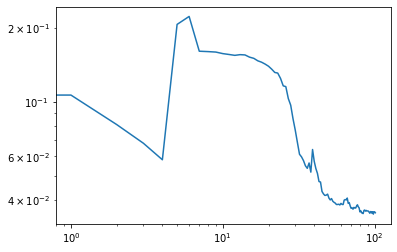

In [13]:
pl.loglog(model.losses)

In [12]:
torch.max(model.new_CA(x))

tensor(18.7935, device='cuda:0', grad_fn=<MaxBackward1>)

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1301.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


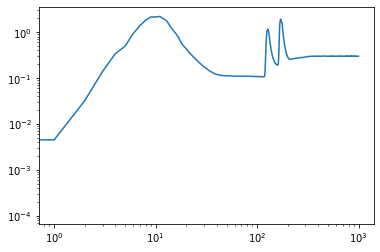

In [10]:
norms = []
with torch.no_grad():
    x = pool.sample(1)[0].cuda()
    for i in range(1000):
        norm = torch.mean(model.old_CA(x)**2)
        norms.append(norm.detach().cpu().item())
        x = model.forward(x)

pl.loglog(norms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


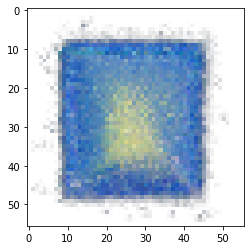

In [18]:
imshow(pool.sample(1)[0][0])

In [17]:
torch.mean(model.new_cells.detach().cpu()**2)

tensor(0.1686)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


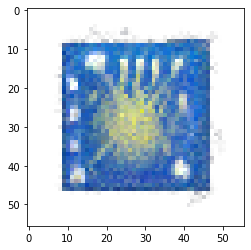

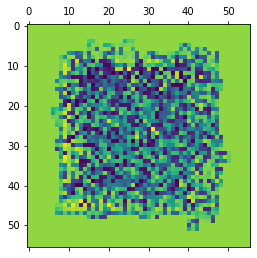

In [16]:
imshow(model.evolve(pool[1:2][0].cuda(), 1000)[0].cpu())
pl.matshow(model.new_cells.detach().cpu()[0,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


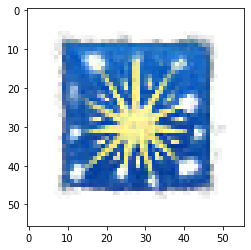

In [17]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

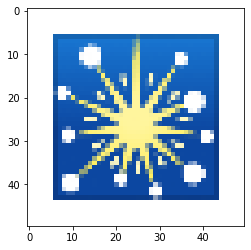

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))